# Praca domowa nr 1

In [1]:
import numpy as np
import pandas as pd

## 1) Wczytanie danych

In [2]:
df = pd.read_stata("HCMST 2017 fresh sample for public sharing draft v1.1.dta")
df.head()

,CaseID,CASEID_NEW,qflag,weight1,weight1_freqwt,weight2,weight1a,weight1a_freqwt,weight_combo,weight_combo_freqwt,...,hcm2017q24_met_through_family,hcm2017q24_met_through_friend,hcm2017q24_met_through_as_nghbrs,hcm2017q24_met_as_through_cowork,w6_subject_race,interracial_5cat,partner_mother_yrsed,subject_mother_yrsed,partner_yrsed,subject_yrsed
0,2,2014039,Qualified,NaN,NaN,0.8945,NaN,NaN,0.277188,19240.0,...,no,no,no,no,White,no,12.0,14.0,12.0,14.0
1,3,2019003,Qualified,0.9078,71115.0,NaN,0.9026,70707.0,1.020621,70841.0,...,no,no,no,yes,White,no,12.0,16.0,17.0,17.0
2,5,2145527,Qualified,0.7205,56442.0,NaN,0.7164,56121.0,0.810074,56227.0,...,no,no,no,no,White,no,9.0,7.5,14.0,17.0
3,6,2648857,Qualified,1.2597,98682.0,1.3507,1.2524,98110.0,0.418556,29052.0,...,no,no,no,no,White,no,16.0,12.0,12.0,12.0
4,7,2623465,Qualified,0.8686,68044.0,NaN,0.8636,67652.0,0.976522,67781.0,...,no,no,yes,no,White,no,14.0,17.0,16.0,16.0


## 2) Budowa modelu

### Przygotowanie danych

In [3]:
df.describe().columns

Index(['CaseID', 'CASEID_NEW', 'weight1', 'weight1_freqwt', 'weight2',
       'weight1a', 'weight1a_freqwt', 'weight_combo', 'weight_combo_freqwt',
       'duration', 'Q16', 'w6_q9', 'w6_q16', 'w6_q17', 'w6_q21a_year',
       'w6_q21b_year', 'w6_q21b_month_flag', 'w6_q21c_year',
       'w6_q21c_month_flag', 'w6_q21d_year', 'w6_q21e_year', 'w6_q21f_year',
       'w6_outness_timing_all', 'w6_q24_length', 'w6_q26',
       'w6_number_people_met', 'relate_duration_at_w6_years',
       'w6_number_people_met_app', 'weight_combo_v2', 'female',
       'year_fraction_met', 'year_fraction_relstart', 'age_when_met',
       'time_from_met_to_rel', 'year_fraction_first_cohab',
       'time_from_rel_to_cohab', 'hcm2017_q24_length',
       'hcm2017q24_summary_all_codes', 'partner_mother_yrsed',
       'subject_mother_yrsed', 'partner_yrsed', 'subject_yrsed'],
      dtype='object')

Wybrane przeze mnie zmienne to:
* ilościowe: 
    - `time_from_rel_to_cohab` -  year_fraction_first_cohab - year_fraction_relstart, negreset to zero 
    - `w6_q24_length` - length of q24 how met answer in characters 
* jakościowe: 
    - `hcm2017q24_church` - met in or through church or religious organization
    - `hcm2017q24_btwn_I_sig_other` - significant other relationship  between intermediaries

In [4]:
myDf = df.loc[:, ["time_from_rel_to_cohab", "w6_q24_length", "hcm2017q24_church", "hcm2017q24_btwn_I_sig_other", "S1"]].dropna()
myDf = myDf.query("time_from_rel_to_cohab > 0")

In [5]:
myDf.loc[:,"hcm2017q24_church"] = myDf.loc[:,"hcm2017q24_church"].map({"yes": 1, "no": 0})
myDf.loc[:,"hcm2017q24_btwn_I_sig_other"] = myDf.loc[:,"hcm2017q24_btwn_I_sig_other"].map({"yes": 1, "no": 0})
myDf.loc[:,"S1"] = myDf.loc[:,"S1"].apply(lambda x: 1 if x.startswith("Yes") else 0).astype(np.int32)

In [6]:
myDf.describe()

,time_from_rel_to_cohab,w6_q24_length,hcm2017q24_church,hcm2017q24_btwn_I_sig_other,S1
count,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000
mean,2.062340,200.837784,0.063417,0.015531,0.768335
std,2.775629,253.214661,0.243764,0.123677,0.421987
min,0.083252,1.000000,0.000000,0.000000,0.000000
25%,0.500000,67.000000,0.000000,0.000000,1.000000
50%,1.166748,136.000000,0.000000,0.000000,1.000000
75%,2.583252,241.000000,0.000000,0.000000,1.000000
max,36.750000,3855.000000,1.000000,1.000000,1.000000


### Klasyfikacja z użyciem XGBoost

In [7]:
import xgboost
import sklearn.model_selection
import sklearn.metrics

In [8]:
xgbModel = xgboost.XGBClassifier()
X = myDf.iloc[:, :4]
Y = myDf.loc[:, "S1"]
cv_scores = sklearn.model_selection.cross_validate(xgbModel, X, Y, cv = 10)

In [9]:
xgbModel.fit(X, Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [10]:
cv_scores["test_score"].mean()

0.7627211831629472

Powyższy wynik prezentuje średnią dokładność klasyfikacji

## 3) Wykresy Ceteris Paribus

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,10)})
sns.set_style("darkgrid")
sns.set_context("talk")

In [20]:
def plot(model, df, feature, nPoints):
    sample = df.sample(n=1, random_state=100)
    featureRange = (df.loc[:, feature].min(), df.loc[:, feature].max())
    x = np.linspace(featureRange[0], featureRange[1], num=nPoints, endpoint=True)
    samples = sample.append([sample.iloc[0, :]]*(nPoints-1), ignore_index=True).reset_index(drop=True)
    samples.loc[:, feature] = x
    y = model.predict_proba(samples)[:,1]
    plt.plot(x, y)
    plt.xlabel(feature)
    plt.ylabel("Married probability")
    plt.ylim(0,1)
    plt.title("Ceteris paribus plot")
    sample_x = sample.loc[:, feature]
    sample_prob = model.predict_proba(sample)[:,1]
    plt.plot(sample_x, sample_prob, "r*", markersize=20)

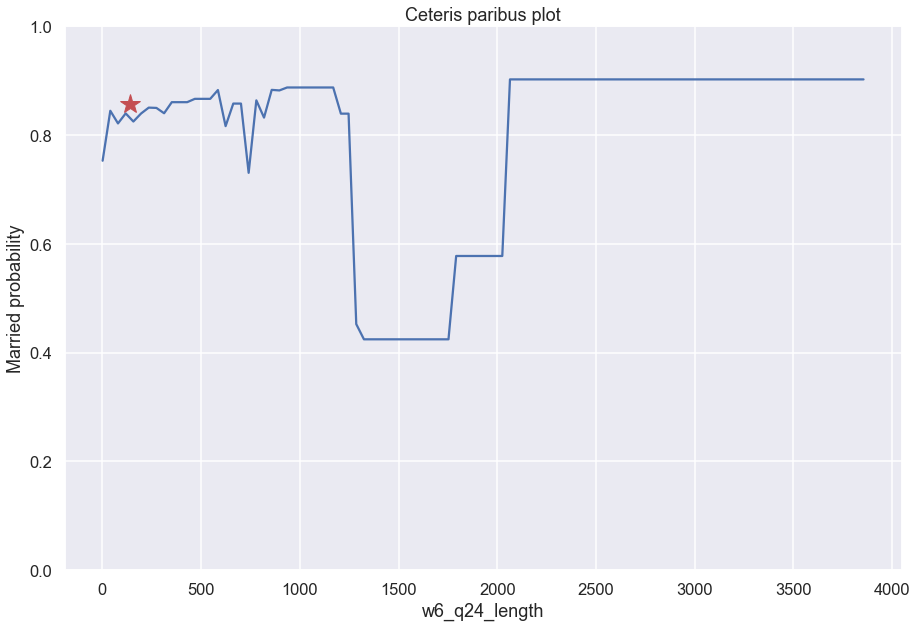

In [21]:
plot(xgbModel, X, "w6_q24_length", 100)

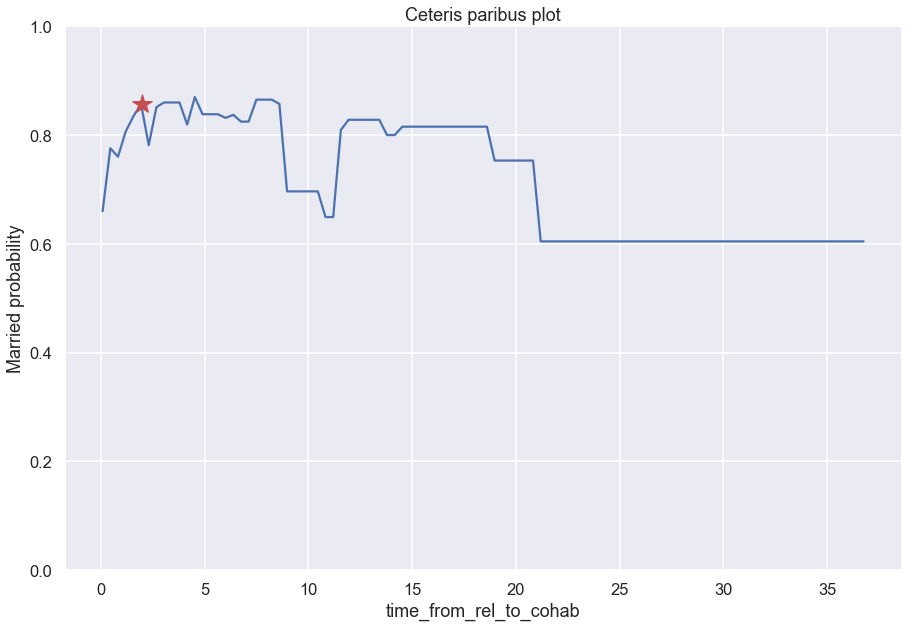

In [22]:
plot(xgbModel, X, "time_from_rel_to_cohab", 100)